<a href="https://colab.research.google.com/github/gkondayya/ACP2021/blob/main/portfolio_rebal_nifty50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 5.9 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [3]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12 # n = no. of years, so for daily data replace 12 with 252 (12 is used for now for monthly data)  
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [ ]:
import bs4 as bs
import pickle
import requests
def save_nifty50_tickers():
    resp=requests.get('https://en.wikipedia.org/wiki/NIFTY_50')
    soup=bs.BeautifulSoup(resp.text,"lxml")
    table=soup.find('table', {'class':'wikitable sortable'})
    tickers=[]
    for row in table.findAll('tr')[1:]:
        ticker= row.findAll('td')[1].text
        tickers.append(ticker)
    with open("nifty50.pickle","wb") as f:
        pickle.dump(tickers,f)
   # print (tickers)
    return tickers
nifty50 = save_nifty50_tickers()
ext = ".NS" 
tickers = [t + ext for t in nifty50 ]
tickers

In [4]:
#tickers = ["AFFLE.NS", "AMBER.NS", "ASIANPAINT.NS", "BAJAJHIND.NS", "BAJFINANCE.NS", "BALKRISIND.NS", "BSE.NS", "CLEAN.NS", "CUPID.NS" , \
#"DIXON.NS", "DMART.NS", "EQUITAS.NS", "HDFC.NS", "HDFCBANK.NS", "ICICIBANK.NS", "IDFC.NS", "IEX.NS", "INFY.NS", "INOXLEISUR.NS" , \
#"IRCTC.NS", "ISGEC.NS", "JPPOWER.NS", "JUBLFOOD.NS", "LIKHITHA.NS", "LT.NS", "MOLDTKPAC.NS","MOTHERSUMI.NS", "NELCO.NS", \
#"PIIND.NS", "POLYCAB.NS", "PRAJIND.NS", "PRECWIRE.NS", "PVR.NS", "RELIANCE.NS", "SBIN.NS", "TATACHEM.NS", "TATAMOTORS.NS", \
#"TCS.NS", "TECHM.NS", "YESBANK.NS", "ZENSARTECH.NS"]


In [17]:
ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(365)
end = dt.datetime.today()


In [18]:
# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [19]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.fillna(method='backfill',inplace=True)

#return_df.tail()


calculating monthly return for  ADANIPORTS.NS
calculating monthly return for  ASIANPAINT.NS
calculating monthly return for  AXISBANK.NS
calculating monthly return for  BAJAJ-AUTO.NS
calculating monthly return for  BAJFINANCE.NS
calculating monthly return for  BAJAJFINSV.NS
calculating monthly return for  BHARTIARTL.NS
calculating monthly return for  BPCL.NS
calculating monthly return for  BRITANNIA.NS
calculating monthly return for  CIPLA.NS
calculating monthly return for  COALINDIA.NS
calculating monthly return for  DIVISLAB.NS
calculating monthly return for  DRREDDY.NS
calculating monthly return for  EICHERMOT.NS
calculating monthly return for  GRASIM.NS
calculating monthly return for  HCLTECH.NS
calculating monthly return for  HDFC.NS
calculating monthly return for  HDFCBANK.NS
calculating monthly return for  HDFCLIFE.NS
calculating monthly return for  HEROMOTOCO.NS
calculating monthly return for  HINDALCO.NS
calculating monthly return for  HINDUNILVR.NS
calculating monthly return f

In [20]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df


In [21]:
#pflio(return_df,42,20)

#calculating overall strategy's KPIs
CAGR(pflio(return_df,10,5))
#sharpe(pflio(return_df,6,3),0.025)
#max_dd(pflio(return_df,6,3)) 

['HINDALCO.NS', 'SBIN.NS', 'ADANIPORTS.NS', 'ONGC.NS', 'INDUSINDBK.NS', 'TATAMOTORS.NS', 'COALINDIA.NS', 'NTPC.NS', 'TATASTEEL.NS', 'BPCL.NS']
['HINDALCO.NS', 'SBIN.NS', 'ADANIPORTS.NS', 'ONGC.NS', 'INDUSINDBK.NS', 'HINDALCO.NS', 'SBIN.NS', 'ADANIPORTS.NS', 'ONGC.NS', 'INDUSINDBK.NS']
['HINDALCO.NS', 'ADANIPORTS.NS', 'HINDALCO.NS', 'ADANIPORTS.NS', 'GRASIM.NS', 'JSWSTEEL.NS', 'UPL.NS', 'HINDUNILVR.NS', 'TATASTEEL.NS', 'ASIANPAINT.NS']
['HINDALCO.NS', 'HINDALCO.NS', 'JSWSTEEL.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS', 'TATASTEEL.NS', 'WIPRO.NS', 'DRREDDY.NS', 'BAJAJFINSV.NS', 'DIVISLAB.NS']
['HINDALCO.NS', 'HINDALCO.NS', 'TATASTEEL.NS', 'TATASTEEL.NS', 'WIPRO.NS', 'UPL.NS', 'IOC.NS', 'SBIN.NS', 'ASIANPAINT.NS', 'BPCL.NS']
['TATASTEEL.NS', 'TATASTEEL.NS', 'WIPRO.NS', 'ASIANPAINT.NS', 'BPCL.NS', 'INFY.NS', 'TATACONSUM.NS', 'TITAN.NS', 'TECHM.NS', 'BAJFINANCE.NS']
['TATASTEEL.NS', 'TATASTEEL.NS', 'WIPRO.NS', 'TECHM.NS', 'BAJFINANCE.NS', 'TATASTEEL.NS', 'HINDALCO.NS', 'BAJAJFINSV.NS', 'SUNPHARMA.N

0.5378982244693316

[*********************100%***********************]  1 of 1 completed
['HINDALCO.NS', 'SBIN.NS', 'ADANIPORTS.NS', 'ONGC.NS', 'INDUSINDBK.NS']
['HINDALCO.NS', 'HINDALCO.NS', 'SBIN.NS', 'ADANIPORTS.NS', 'ONGC.NS']
['ADANIPORTS.NS', 'GRASIM.NS', 'JSWSTEEL.NS', 'UPL.NS', 'HINDUNILVR.NS']
['JSWSTEEL.NS', 'JSWSTEEL.NS', 'TATASTEEL.NS', 'WIPRO.NS', 'DRREDDY.NS']
['WIPRO.NS', 'UPL.NS', 'IOC.NS', 'SBIN.NS', 'ASIANPAINT.NS']
['WIPRO.NS', 'INFY.NS', 'TATACONSUM.NS', 'TITAN.NS', 'TECHM.NS']
['TECHM.NS', 'TATASTEEL.NS', 'HINDALCO.NS', 'BAJAJFINSV.NS', 'SUNPHARMA.NS']
['TECHM.NS', 'TECHM.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'TCS.NS']
['BAJAJFINSV.NS', 'COALINDIA.NS', 'NTPC.NS', 'ONGC.NS', 'TATAMOTORS.NS']
['TATAMOTORS.NS', 'TATAMOTORS.NS', 'ICICIBANK.NS', 'SBIN.NS', 'TITAN.NS']
['TITAN.NS', 'POWERGRID.NS', 'CIPLA.NS', 'BHARTIARTL.NS', 'TECHM.NS']
['TECHM.NS', 'HINDALCO.NS', 'UPL.NS', 'TECHM.NS', 'JSWSTEEL.NS']
['COALINDIA.NS', 'POWERGRID.NS', 'ITC.NS', 'BAJFINANCE.NS', 'IOC.NS']


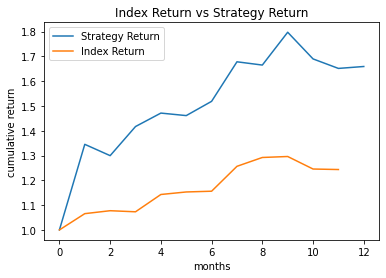

In [25]:
#calculating KPIs for Index buy and hold strategy over the same period
Nifty50 = yf.download("^NSEI",dt.date.today()-dt.timedelta(365),dt.date.today(),interval='1mo')
Nifty50["mon_ret"] = Nifty50["Adj Close"].pct_change().fillna(0)
CAGR(Nifty50)
sharpe(Nifty50,0.025)
max_dd(Nifty50)

#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,5,4)).cumprod())
plt.plot((1+Nifty50["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])